In [100]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

np.random.seed(42)
torch.manual_seed(42)

In [101]:
class config:
    image_size = (64, 64) 
    components = 50  # PCA components
    batch_size = 16  
    hidden_size = 128  
    learning_rate = 0.001 
    epochs = 50  
    
config = config()

In [102]:
def load_rgb_images(folder, label, size=config.image_size):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder), desc=f"Loading RGB from {folder}"):
        if filename.endswith('.jpg') or filename.endswith('.tiff'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB').resize(size)
            images.append(np.array(img).flatten()) 
            labels.append(label)
    return images, labels


def load_ndvi_images(folder, size=config.image_size):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder), desc=f"Loading NDVI from {folder}"):
        if filename.endswith('.jpg') or filename.endswith('.tiff'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize(size)  
            images.append(np.array(img).flatten()) 
            filenames.append(filename)
    return images, filenames


In [103]:
samples_folder = 'samples'
rgb_images, rgb_labels = load_rgb_images(samples_folder, label=1)

labels_folder = 'labels'
ndvi_images, filenames = load_ndvi_images(labels_folder)

rgb_array = np.array(rgb_images)
labels_array = np.array(ndvi_images)

print(f"Loaded {rgb_array.shape[0]} RGB images")
print(f"RGB array shape: {rgb_array.shape}")
print(f"Loaded {labels_array.shape[0]} NDVI images")
print(f"NDVI array shape: {labels_array.shape}")

Loading NDVI from labels: 100%|██████████| 614/614 [00:00<00:00, 2283.84it/s]

Loaded 614 RGB images
RGB array shape: (614, 12288)
Loaded 614 NDVI images
NDVI array shape: (614, 4096)


In [104]:
# Create binary labels from NDVI values
# Calculate mean NDVI for each image
mean_ndvi = np.nanmean(labels_array, axis=1)

# Use median as threshold
threshold = np.median(mean_ndvi)
print(f"NDVI threshold (median): {threshold:.4f}")

# Create binary labels: 1 = Healthy (above threshold), 0 = Unhealthy (below threshold)
y_labels = (mean_ndvi > threshold).astype(int)

print(f"Number of Healthy (1): {np.sum(y_labels == 1)}")
print(f"Number of Unhealthy (0): {np.sum(y_labels == 0)}")

NDVI threshold (median): 176.6279
Number of Healthy (1): 307
Number of Unhealthy (0): 307


In [105]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    rgb_array, y_labels, test_size=0.2, random_state=40, stratify=y_labels
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set class distribution: 0={np.sum(y_train==0)}, 1={np.sum(y_train==1)}")
print(f"Test set class distribution: 0={np.sum(y_test==0)}, 1={np.sum(y_test==1)}")

Training set size: 491
Test set size: 123
Training set class distribution: 0=245, 1=246
Test set class distribution: 0=62, 1=61


In [106]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=config.components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original feature dimension: {X_train.shape[1]}")
print(f"Reduced feature dimension: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

Original feature dimension: 12288
Reduced feature dimension: 50
Explained variance ratio: 0.7745


## Simple NN

In [107]:
# Define Simple Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x) 
        x = self.relu(x)  
        x = self.fc2(x) 
        return x

input_size = config.components 
hidden_size = config.hidden_size 
num_classes = 2  # Healthy vs Unhealthy

model = SimpleNN(input_size, hidden_size, num_classes)

# Preparation of Data

In [108]:
# Convert numpy arrays to tensors
X_train_tensor = torch.FloatTensor(X_train_pca)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_pca)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 31
Test batches: 8


In [109]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# raining Loop


In [110]:
for epoch in range(config.epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{config.epochs} completed')

Epoch 10/50 completed
Epoch 20/50 completed
Epoch 20/50 completed
Epoch 30/50 completed
Epoch 30/50 completed
Epoch 40/50 completed
Epoch 40/50 completed
Epoch 50/50 completed
Epoch 50/50 completed


## Evaluation

In [111]:
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).argmax(dim=1).numpy()

print(classification_report(y_test, y_pred_nn, target_names=['Unhealthy', 'Healthy']))

              precision    recall  f1-score   support

   Unhealthy       0.62      0.58      0.60        62
     Healthy       0.60      0.64      0.62        61

    accuracy                           0.61       123
   macro avg       0.61      0.61      0.61       123
weighted avg       0.61      0.61      0.61       123



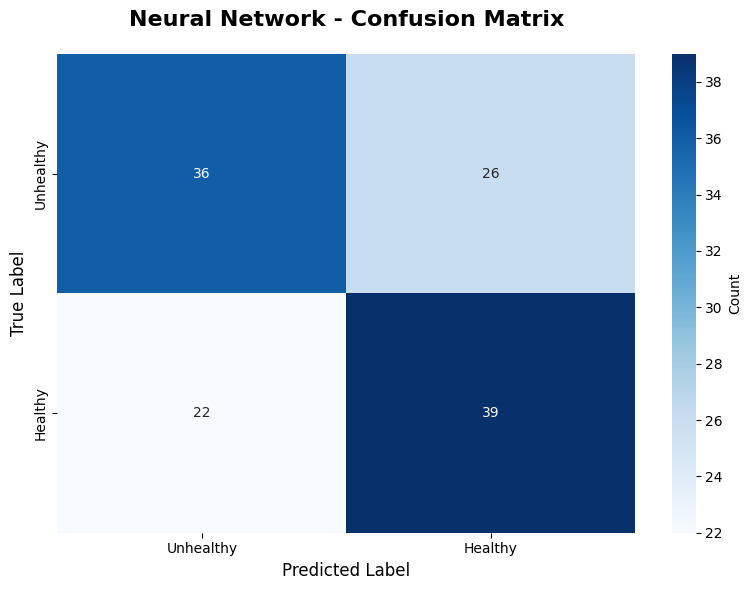

In [112]:
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d')
plt.show()